# Comprehensive ASO (Antisense Oligonucleotide) Analysis Pipeline

## Overview
This notebook provides a complete analysis pipeline for ASO data including:
- **Data loading and preprocessing**
- **Exon sequence extraction from Ensembl**
- **Homopolymer detection and analysis**
- **GC content and sequence analysis**
- **Energy analysis (binding energy, MFE)**
- **Molecular weight and concentration calculations**
- **Comprehensive visualization and reporting**

---

## 1. Setup and Dependencies

Install required packages and import necessary libraries.

In [ ]:
# Install required packages (uncomment if needed)
# !pip install biopython pyranges ViennaRNA

# Note: These packages provide advanced functionality:
# - biopython: For biological sequence analysis
# - pyranges: For genomic interval operations
# - ViennaRNA: For RNA secondary structure and energy calculations

In [1]:
# Core data analysis libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Utility libraries
from pathlib import Path
import warnings
import requests
import json
import re
import time
from typing import Dict, List, Tuple, Optional, Any

# Configuration
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output
plt.style.use('default')           # Set consistent plotting style
sns.set_palette("husl")            # Set color palette

# Pandas display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✅ All libraries imported successfully")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")

✅ All libraries imported successfully
📊 Pandas version: 2.2.2
🔢 NumPy version: 2.0.2


## 2. Configuration and Constants

Set up configuration parameters and constants for the analysis.

In [2]:
# File paths and configuration
DATA_FILE = 'ASO_table_no_mod.csv'
OUTPUT_DIR = Path('output')

# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(exist_ok=True)

# Ensembl API configuration
ENSEMBL_BASE_URL = "https://rest.ensembl.org"
REQUEST_HEADERS = {"Content-Type": "application/json"}

# Analysis parameters
MIN_HOMOPOLYMER_LENGTH = 4  # Minimum length for homopolymer detection
API_DELAY = 0.1  # Delay between API requests (seconds)

print("⚙️ Configuration set up successfully")
print(f"📁 Output directory: {OUTPUT_DIR}")
print(f"🌐 Ensembl API: {ENSEMBL_BASE_URL}")

⚙️ Configuration set up successfully
📁 Output directory: output
🌐 Ensembl API: https://rest.ensembl.org


## 3. Data Loading and Initial Exploration

Load the ASO dataset and perform initial data exploration.

In [3]:
# Load the dataset
try:
    df = pd.read_csv(DATA_FILE)
    print(f"✅ Successfully loaded dataset")
    print(f"📋 Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Display basic information
    print(f"\n📊 Column Overview:")
    print(f"Columns: {list(df.columns)}")

except FileNotFoundError:
    print(f"❌ Error: File '{DATA_FILE}' not found")
    print("Please ensure the data file is in the current directory")
except Exception as e:
    print(f"❌ Error loading data: {e}")

✅ Successfully loaded dataset
📋 Shape: 13,072 rows × 27 columns
💾 Memory usage: 18.54 MB

📊 Column Overview:
Columns: ['source_type', 'name', 'id', 'target_gene', 'exon_or_intron', 'number_exon_intron', 'target_variant', 'species', 'cell_line', 'delivery_approach', 'aso_type', 'oligo_sequence', 'modification', 'modification_mask', 'concentration', 'concentration_unit', 'type_of_efficiency', 'efficiency', 'efficiency_units', 'efficiency_text', 'comment', 'DNA.RNA', 'link', 'top1_hit', 'top1_real', 'top1_predicted', 'no_mod_ASO']


In [21]:
#Operating only with human data
df = df[df['species'] == 'human']

In [22]:
# Display detailed dataset information
print("📊 DATASET OVERVIEW")
print("=" * 50)

# Show first few rows
print("\n🔍 First 5 rows:")
display(df.head())

# Show column information with data types and missing values
print("\n📋 Column Information:")
print("-" * 70)
print(f"{'#':<3} {'Column Name':<25} {'Data Type':<12} {'Null Count':<10} {'Null %':<8}")
print("-" * 70)

for i, col in enumerate(df.columns, 1):
    dtype = str(df[col].dtype)
    null_count = df[col].isnull().sum()
    null_pct = (null_count / len(df)) * 100
    print(f"{i:<3} {col:<25} {dtype:<12} {null_count:<10} {null_pct:<8.1f}%")

📊 DATASET OVERVIEW

🔍 First 5 rows:


,source_type,name,id,target_gene,exon_or_intron,number_exon_intron,target_variant,species,cell_line,delivery_approach,aso_type,oligo_sequence,modification,modification_mask,concentration,concentration_unit,type_of_efficiency,efficiency,efficiency_units,efficiency_text,comment,DNA.RNA,link,top1_hit,top1_real,top1_predicted,no_mod_ASO,no_mod_ASO_count,no_mod_ASO_max_length,no_mod_ASO_has_homopolymers,no_mod_ASO_length,no_mod_ASO_gc_content,molecular_weight,converted_value_uM
20,journal article,Personalized Exon Skipping Strategies To Addre...,PMID 20817455,DMD,exon,17/18,NaN,human,Normal human myoblasts,"Lipofectamine 2000, opti-MEM",NaN,agugauggcugagugguggugacagc/cugcaacacagcuucugag...,2OMe,NaN,25,nM,NaN,32.46,NaN,NaN,NaN,RNA,https://pubmed.ncbi.nlm.nih.gov/20817455,NaN,NaN,NaN,AGUGAUGGCUGAGUGGUGGUGACAGC/CUGCAACACAGCUUCUGAG...,0,0,False,58,54.385965,17591.545,1421.137257
21,journal article,Personalized Exon Skipping Strategies To Addre...,PMID 20817455,DMD,exon,17/18,NaN,human,Normal human myoblasts,"Lipofectamine 2000, opti-MEM",NaN,agugauggcugagugguggugacagc/cugcaacacagcuucugag...,2OMe,NaN,50,nM,NaN,58.69,NaN,NaN,NaN,RNA,https://pubmed.ncbi.nlm.nih.gov/20817455,ERROR,ERROR,ERROR,AGUGAUGGCUGAGUGGUGGUGACAGC/CUGCAACACAGCUUCUGAG...,0,0,False,58,54.385965,17591.545,2842.274513
22,journal article,Personalized Exon Skipping Strategies To Addre...,PMID 20817455,DMD,exon,17/18,NaN,human,Normal human myoblasts,"Lipofectamine 2000, opti-MEM",NaN,agugauggcugagugguggugacagc/cugcaacacagcuucugag...,2OMe,NaN,100,nM,NaN,60.33,NaN,NaN,NaN,RNA,https://pubmed.ncbi.nlm.nih.gov/20817455,ERROR,ERROR,ERROR,AGUGAUGGCUGAGUGGUGGUGACAGC/CUGCAACACAGCUUCUGAG...,0,0,False,58,54.385965,17591.545,5684.549026
23,journal article,Personalized Exon Skipping Strategies To Addre...,PMID 20817455,DMD,exon,17/18,NaN,human,Normal human myoblasts,"Lipofectamine 2000, opti-MEM",NaN,agugauggcugagugguggugacagc/cugcaacacagcuucugag...,2OMe,NaN,300,nM,NaN,81.31,NaN,NaN,NaN,RNA,https://pubmed.ncbi.nlm.nih.gov/20817455,ERROR,ERROR,ERROR,AGUGAUGGCUGAGUGGUGGUGACAGC/CUGCAACACAGCUUCUGAG...,0,0,False,58,54.385965,17591.545,17053.647079
24,journal article,Personalized Exon Skipping Strategies To Addre...,PMID 20817455,DMD,exon,17/18,NaN,human,Normal human myoblasts,"Lipofectamine 2000, opti-MEM",NaN,agugauggcugagugguggugacagc/cugcaacacagcuucugag...,2OMe,NaN,600,nM,NaN,84.1,NaN,NaN,NaN,RNA,https://pubmed.ncbi.nlm.nih.gov/20817455,ERROR,ERROR,ERROR,AGUGAUGGCUGAGUGGUGGUGACAGC/CUGCAACACAGCUUCUGAG...,0,0,False,58,54.385965,17591.545,34107.294158



📋 Column Information:
----------------------------------------------------------------------
#   Column Name               Data Type    Null Count Null %  
----------------------------------------------------------------------
1   source_type               object       0          0.0     %
2   name                      object       0          0.0     %
3   id                        object       0          0.0     %
4   target_gene               object       0          0.0     %
5   exon_or_intron            object       0          0.0     %
6   number_exon_intron        object       0          0.0     %
7   target_variant            float64      11117      100.0   %
8   species                   object       0          0.0     %
9   cell_line                 object       0          0.0     %
10  delivery_approach         object       0          0.0     %
11  aso_type                  object       11117      100.0   %
12  oligo_sequence            object       0          0.0     %
13  

## 4. Exon Sequence Extraction

Extract exon sequences from Ensembl database for genes in the dataset.

In [5]:
class EnsemblExonExtractor:
    """
    Class for extracting exon sequences from Ensembl database
    """

    def __init__(self, base_url: str = ENSEMBL_BASE_URL):
        """Initialize the Ensembl exon extractor"""
        self.base_url = base_url
        self.headers = REQUEST_HEADERS

    def get_gene_id(self, gene_symbol: str, species: str = "human") -> Optional[str]:
        """Get Ensembl gene ID from gene symbol"""
        try:
            url = f"{self.base_url}/lookup/symbol/{species}/{gene_symbol}"
            response = requests.get(url, headers=self.headers)

            if response.status_code == 200:
                data = response.json()
                return data.get('id')
            else:
                return None

        except Exception as e:
            print(f"Exception getting gene ID for {gene_symbol}: {e}")
            return None

    def get_canonical_transcript(self, gene_id: str) -> Optional[str]:
        """Get canonical transcript ID for a gene"""
        try:
            url = f"{self.base_url}/lookup/id/{gene_id}?expand=1"
            response = requests.get(url, headers=self.headers)

            if response.status_code == 200:
                data = response.json()
                transcripts = data.get('Transcript', [])

                # Find canonical transcript
                for transcript in transcripts:
                    if transcript.get('is_canonical') == 1:
                        return transcript.get('id')

                # If no canonical found, return first transcript
                if transcripts:
                    return transcripts[0].get('id')

            return None

        except Exception as e:
            print(f"Exception getting canonical transcript: {e}")
            return None

    def get_transcript_exons(self, transcript_id: str) -> List[Dict]:
        """Get all exons for a transcript"""
        try:
            url = f"{self.base_url}/lookup/id/{transcript_id}?expand=1"
            response = requests.get(url, headers=self.headers)

            if response.status_code == 200:
                data = response.json()
                exons = data.get('Exon', [])
                return exons
            else:
                return []

        except Exception as e:
            print(f"Exception getting transcript exons: {e}")
            return []

    def get_exon_sequence(self, exon_id: str) -> Optional[str]:
        """Get sequence for a specific exon"""
        try:
            url = f"{self.base_url}/sequence/id/{exon_id}"
            response = requests.get(url, headers=self.headers)

            if response.status_code == 200:
                data = response.json()
                return data.get('seq')
            else:
                return None

        except Exception as e:
            print(f"Exception getting exon sequence: {e}")
            return None

    def get_exon_sequence_by_number(self, gene_symbol: str, exon_number: int,
                                   species: str = "human") -> Tuple[Optional[str], Dict]:
        """Get exon sequence by gene symbol and exon number"""
        metadata = {
            'gene_symbol': gene_symbol,
            'exon_number': exon_number,
            'species': species,
            'gene_id': None,
            'transcript_id': None,
            'exon_id': None,
            'sequence_length': None,
            'error': None
        }

        try:
            # Step 1: Get gene ID
            gene_id = self.get_gene_id(gene_symbol, species)
            if not gene_id:
                metadata['error'] = f"Gene {gene_symbol} not found"
                return None, metadata

            metadata['gene_id'] = gene_id

            # Step 2: Get canonical transcript
            transcript_id = self.get_canonical_transcript(gene_id)
            if not transcript_id:
                metadata['error'] = f"No transcript found for gene {gene_symbol}"
                return None, metadata

            metadata['transcript_id'] = transcript_id

            # Step 3: Get all exons for the transcript
            exons = self.get_transcript_exons(transcript_id)
            if not exons:
                metadata['error'] = f"No exons found for transcript {transcript_id}"
                return None, metadata

            # Step 4: Find the specific exon by number
            if exon_number <= 0 or exon_number > len(exons):
                metadata['error'] = f"Exon {exon_number} not found. Gene {gene_symbol} has {len(exons)} exons"
                return None, metadata

            # Exons are typically ordered, but let's sort by start position to be sure
            exons_sorted = sorted(exons, key=lambda x: x['start'], reverse=True)
            target_exon = exons_sorted[exon_number - 1]  # Convert to 0-based index
            metadata['exon_id'] = target_exon['id']

            # Step 5: Get the exon sequence
            sequence = self.get_exon_sequence(target_exon['id'])
            if sequence:
                metadata['sequence_length'] = len(sequence)
                return sequence, metadata
            else:
                metadata['error'] = f"Failed to retrieve sequence for exon {target_exon['id']}"
                return None, metadata

        except Exception as e:
            metadata['error'] = f"Unexpected error: {str(e)}"
            return None, metadata

print("🧬 EnsemblExonExtractor class defined successfully")

🧬 EnsemblExonExtractor class defined successfully


<ipython-input-11-1438393359>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['a_numeric'] = pd.to_numeric(df_new['number_exon_intron'], errors='coerce')


In [23]:
# Correct number exon preparation
df['a_numeric'] = pd.to_numeric(df['number_exon_intron'], errors='coerce')
mask = (df['a_numeric'].notna()) & \
       (df['a_numeric'] >= 1) & \
       (df['a_numeric'] <= 100)
df = df[mask].copy()

In [24]:
# Extract exon sequences for genes in the dataset
def extract_exon_sequences(df, gene_col='target_gene', exon_col='number_exon_intron'):
    """
    Extract exon sequences for genes in the dataset
    """
    print("\n" + "="*60)
    print("EXON SEQUENCE EXTRACTION")
    print("="*60)

    # Filter for exon entries only
    if 'exon_or_intron' in df.columns:
        exon_df = df[df['exon_or_intron'] == 'exon'].copy()
        print(f"Found {len(exon_df)} exon entries")
    else:
        exon_df = df.copy()
        print(f"Processing all {len(exon_df)} entries")

    # Check if required columns exist
    if gene_col not in exon_df.columns or exon_col not in exon_df.columns:
        print(f"❌ Required columns '{gene_col}' or '{exon_col}' not found")
        return None

    # Get unique gene-exon combinations
    unique_combinations = exon_df[[gene_col, exon_col]].drop_duplicates()
    print(f"Found {len(unique_combinations)} unique gene-exon combinations")

    # Initialize the extractor
    extractor = EnsemblExonExtractor()

    # Extract sequences
    results = []
    print("\nStarting exon sequence extraction...")

    for idx, (_, row) in enumerate(unique_combinations.iterrows()):
        gene_symbol = row[gene_col]
        try:
            exon_number = int(row[exon_col])
        except (ValueError, TypeError):
            print(f"⚠️  Invalid exon number for {gene_symbol}: {row[exon_col]}")
            continue

        print(f"Processing {idx+1}/{len(unique_combinations)}: {gene_symbol} exon {exon_number}")

        # Get the exon sequence
        sequence, metadata = extractor.get_exon_sequence_by_number(gene_symbol, exon_number)

        # Prepare result record
        result = {
            'gene_symbol': gene_symbol,
            'exon_number': exon_number,
            'gene_id': metadata.get('gene_id'),
            'transcript_id': metadata.get('transcript_id'),
            'exon_id': metadata.get('exon_id'),
            'sequence': sequence if sequence else '',
            'sequence_length': metadata.get('sequence_length', 0),
            'status': 'success' if sequence else 'failed',
            'error_message': metadata.get('error', '')
        }
        results.append(result)

        # Progress update every 10 entries
        if (idx + 1) % 10 == 0:
            successful = sum(1 for r in results if r['status'] == 'success')
            print(f"Progress: {idx+1}/{len(unique_combinations)} - {successful} successful")

        # Add delay to be respectful to Ensembl API
        time.sleep(API_DELAY)

    # Create results DataFrame
    results_df = pd.DataFrame(results)

    # Print summary
    successful = len(results_df[results_df['status'] == 'success'])
    failed = len(results_df[results_df['status'] == 'failed'])

    print(f"\n=== EXTRACTION SUMMARY ===")
    print(f"Total combinations processed: {len(results_df)}")
    print(f"Successful extractions: {successful}")
    print(f"Failed extractions: {failed}")
    print(f"Success rate: {successful/len(results_df)*100:.1f}%")

    return results_df



print("🧬 Exon extraction functions ready")


EXON SEQUENCE EXTRACTION
Found 10720 exon entries
Found 152 unique gene-exon combinations

Starting exon sequence extraction...
Processing 1/152: DMD exon 46
Processing 2/152: DMD exon 51
Processing 3/152: DMD exon 45
Processing 4/152: DMD exon 44
Processing 5/152: DMD exon 22
Processing 6/152: DMD exon 23
Processing 7/152: DMD exon 24
Processing 8/152: DMD exon 20
Processing 9/152: DMD exon 53
Processing 10/152: DMD exon 16
Progress: 10/152 - 10 successful
Processing 11/152: DMD exon 50
Processing 12/152: DMD exon 55
Processing 13/152: DYSF exon 19
Processing 14/152: DYSF exon 24
Processing 15/152: DYSF exon 30
Processing 16/152: DYSF exon 32
Processing 17/152: DYSF exon 34
Processing 18/152: MAPT exon 1
Processing 19/152: MAPT exon 5
Processing 20/152: MAPT exon 4
Progress: 20/152 - 20 successful
Processing 21/152: MAPT exon 12
Processing 22/152: USH2A exon 13
Processing 23/152: COL7A1 exon 10
Processing 24/152: COL7A1 exon 73
Processing 25/152: COL7A1 exon 70
Processing 26/152: PAH

ValueError: You are trying to merge on object and int64 columns for key 'number_exon_intron'. If you wish to proceed you should use pd.concat

In [26]:
df.columns

Index(['source_type', 'name', 'id', 'target_gene', 'exon_or_intron',
       'number_exon_intron', 'target_variant', 'species', 'cell_line',
       'delivery_approach', 'aso_type', 'oligo_sequence', 'modification',
       'modification_mask', 'concentration', 'concentration_unit',
       'type_of_efficiency', 'efficiency', 'efficiency_units',
       'efficiency_text', 'comment', 'DNA.RNA', 'link', 'top1_hit',
       'top1_real', 'top1_predicted', 'no_mod_ASO', 'no_mod_ASO_count',
       'no_mod_ASO_max_length', 'no_mod_ASO_has_homopolymers',
       'no_mod_ASO_length', 'no_mod_ASO_gc_content', 'molecular_weight',
       'converted_value_uM', 'a_numeric'],
      dtype='object')

In [28]:
# Run exon extraction (uncomment to execute)
exon_results = extract_exon_sequences(df)
if exon_results is not None:
     # Merge with original data
     df['number_exon_intron'] = pd.to_numeric(df['number_exon_intron'], errors='coerce')
     #merged_df = pd.merge(exon_results, df, on=['gene_symbol', 'exon_number'], how='right')
     df_merged = df.merge(
         exon_results[['gene_symbol', 'exon_number', 'sequence']],
         left_on=['target_gene', 'number_exon_intron'],
         right_on=['gene_symbol', 'exon_number'],
         how='left'
     )

     print(f"✅ Merged data shape: {df_merged.shape}")

✅ Merged data shape: (10729, 38)


In [30]:
#Show merged data
df_merged.head(5)

,source_type,name,id,target_gene,exon_or_intron,number_exon_intron,target_variant,species,cell_line,delivery_approach,aso_type,oligo_sequence,modification,modification_mask,concentration,concentration_unit,type_of_efficiency,efficiency,efficiency_units,efficiency_text,comment,DNA.RNA,link,top1_hit,top1_real,top1_predicted,no_mod_ASO,no_mod_ASO_count,no_mod_ASO_max_length,no_mod_ASO_has_homopolymers,no_mod_ASO_length,no_mod_ASO_gc_content,molecular_weight,converted_value_uM,a_numeric,gene_symbol,exon_number,sequence
0,journal article,Antisense-Induced Exon Skipping Restores Dystr...,PMID 11468272,DMD,exon,46.0,NaN,human,"Primary human myotubes (healthy, del45)","PEI, AON linked to PEI at a ratio of 3.5",NaN,guuaucugcuuccuccaacc,2OMe,NaN,1,uM,Null,unspecified,NaN,NaN,NaN,RNA,https://pubmed.ncbi.nlm.nih.gov/11468272,ERROR,ERROR,ERROR,GUUAUCUGCUUCCUCCAACC,0,0,False,20,50.000000,5960.715,167.765109,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...
1,journal article,Antisense-Induced Exon Skipping Restores Dystr...,PMID 11468272,DMD,exon,46.0,NaN,human,"Primary human myotubes (healthy, del45)","PEI, AON linked to PEI at a ratio of 3.5",NaN,uugcugcucuuuucc,2OMe,NaN,1,uM,Null,unspecified,NaN,NaN,NaN,RNA,https://pubmed.ncbi.nlm.nih.gov/11468272,ERROR,ERROR,ERROR,UUGCUGCUCUUUUCC,1,4,True,15,46.666667,4443.790,225.033136,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...
2,journal article,Comparative Analysis Of Antisense Oligonucleot...,PMID 15229633,DMD,exon,46.0,NaN,human,Primary healthy human myotubes,"PEI, 3.5 ul per ug AO",NaN,gcttttcttttagttgctgctc,unmodified PMO,NaN,1,uM,Skip,6,NaN,NaN,NaN,DNA,https://pubmed.ncbi.nlm.nih.gov/15229633,ERROR,ERROR,ERROR,GCTTTTCTTTTAGTTGCTGCTC,2,4,True,22,40.909091,6744.085,148.278084,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...
3,journal article,Comparative Analysis Of Antisense Oligonucleot...,PMID 15229633,DMD,exon,46.0,NaN,human,Primary healthy human myotubes,"PEI, 3.5 ul per ug AO",NaN,cttttagttgctgc,Others (LNA),NaN,500,nM,Skip,85,NaN,NaN,NaN,DNA,https://pubmed.ncbi.nlm.nih.gov/15229633,ERROR,ERROR,ERROR,CTTTTAGTTGCTGC,1,4,True,14,42.857143,4315.605,115858.610786,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...
4,journal article,Comparative Analysis Of Antisense Oligonucleot...,PMID 15229633,DMD,exon,46.0,NaN,human,Primary healthy human myotubes,"PEI, 3.5 ul per ug AO",NaN,cttttagttgctgc,Others (PNA),NaN,20,uM,Null,data not shown,NaN,NaN,NaN,DNA,https://pubmed.ncbi.nlm.nih.gov/15229633,ERROR,ERROR,ERROR,CTTTTAGTTGCTGC,1,4,True,14,42.857143,4315.605,4634.344431,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...


## 5. Homopolymer Detection and Analysis

Detect and analyze homopolymer runs in ASO and exon sequences.

In [7]:
class HomopolymerAnalyzer:
    """
    Class for detecting and analyzing homopolymer runs in sequences
    """

    def __init__(self):
        """Initialize the homopolymer analyzer"""
        pass

    def detect_homopolymers(self, sequence: str, min_length: int = MIN_HOMOPOLYMER_LENGTH) -> Dict:
        """
        Detect homopolymer runs in a sequence.

        Args:
            sequence (str): DNA or RNA sequence
            min_length (int): Minimum length of homopolymer to detect

        Returns:
            dict: Dictionary with homopolymer information
        """
        if not sequence or not isinstance(sequence, str):
            return {
                'runs': [],
                'count': 0,
                'max_length': 0,
                'has_homopolymers': False
            }

        # Clean sequence
        clean_seq = sequence.strip().upper()

        # Find homopolymer runs using regex
        homopolymer_runs = []
        max_length = 0

        # Pattern to find runs of identical nucleotides
        pattern = r'([ATCGU])\1{' + str(min_length - 1) + ',}'

        for match in re.finditer(pattern, clean_seq):
            start_pos = match.start()
            end_pos = match.end()
            nucleotide = match.group(1)
            length = end_pos - start_pos

            homopolymer_runs.append((start_pos, end_pos, nucleotide))
            max_length = max(max_length, length)

        return {
            'runs': homopolymer_runs,
            'count': len(homopolymer_runs),
            'max_length': max_length,
            'has_homopolymers': len(homopolymer_runs) > 0
        }

    def analyze_dataframe(self, df: pd.DataFrame, sequence_cols: List[str],
                         min_length: int = MIN_HOMOPOLYMER_LENGTH) -> pd.DataFrame:
        """
        Analyze homopolymers for all sequences in specified columns

        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame containing sequences
        sequence_cols : List[str]
            List of column names containing sequences
        min_length : int
            Minimum homopolymer length to detect

        Returns:
        --------
        pd.DataFrame
            DataFrame with added homopolymer analysis columns
        """
        df_copy = df.copy()

        for col in sequence_cols:
            if col in df_copy.columns:
                print(f"\n🔍 Analyzing homopolymers in {col}...")

                # Initialize new columns
                df_copy[f'{col}_count'] = 0
                df_copy[f'{col}_max_length'] = 0
                df_copy[f'{col}_has_homopolymers'] = False

                # Analyze each sequence
                for index, row in df_copy.iterrows():
                    if pd.notna(row[col]):
                        result = self.detect_homopolymers(row[col], min_length)

                        df_copy.at[index, f'{col}_count'] = result['count']
                        df_copy.at[index, f'{col}_max_length'] = result['max_length']
                        df_copy.at[index, f'{col}_has_homopolymers'] = result['has_homopolymers']

                # Print summary
                total_with_homo = df_copy[f'{col}_has_homopolymers'].sum()
                total_sequences = df_copy[col].notna().sum()
                if total_sequences > 0:
                    print(f"  Sequences with homopolymers: {total_with_homo}/{total_sequences} ({total_with_homo/total_sequences*100:.1f}%)")

                    if total_with_homo > 0:
                        avg_count = df_copy[df_copy[f'{col}_has_homopolymers']][f'{col}_count'].mean()
                        max_length = df_copy[f'{col}_max_length'].max()
                        print(f"  Average homopolymers per sequence: {avg_count:.1f}")
                        print(f"  Maximum homopolymer length: {max_length}")
            else:
                print(f"⚠️  Column '{col}' not found in dataset")

        return df_copy

print("🔗 HomopolymerAnalyzer class defined successfully")

🔗 HomopolymerAnalyzer class defined successfully


In [31]:
df = df_merged.copy()

In [34]:
# Run homopolymer analysis
print("\n" + "="*60)
print("HOMOPOLYMER ANALYSIS")
print("="*60)

# Initialize analyzer
homopolymer_analyzer = HomopolymerAnalyzer()

# Define sequence columns to analyze
sequence_columns = ['no_mod_ASO']
if 'sequence' in df.columns:
    sequence_columns.append('sequence')

# Check which columns are available
available_columns = [col for col in sequence_columns if col in df.columns]
print(f"Available sequence columns: {available_columns}")

if available_columns:
    # Run analysis
    df_with_homopolymers = homopolymer_analyzer.analyze_dataframe(df, available_columns)

    # Display results
    print(f"\n✅ Homopolymer analysis completed")
    print(f"New columns added: {[col for col in df_with_homopolymers.columns if col not in df.columns]}")

    # Update main dataframe
    df = df_with_homopolymers
else:
    print("⚠️  No sequence columns found for homopolymer analysis")


HOMOPOLYMER ANALYSIS
Available sequence columns: ['no_mod_ASO', 'sequence']

🔍 Analyzing homopolymers in no_mod_ASO...
  Sequences with homopolymers: 2206/10729 (20.6%)
  Average homopolymers per sequence: 1.2
  Maximum homopolymer length: 13

🔍 Analyzing homopolymers in sequence...
  Sequences with homopolymers: 9514/10720 (88.8%)
  Average homopolymers per sequence: 2.6
  Maximum homopolymer length: 22

✅ Homopolymer analysis completed
New columns added: []


In [37]:
df.head(5)

,source_type,name,id,target_gene,exon_or_intron,number_exon_intron,target_variant,species,cell_line,delivery_approach,aso_type,oligo_sequence,modification,modification_mask,concentration,concentration_unit,type_of_efficiency,efficiency,efficiency_units,efficiency_text,comment,DNA.RNA,link,top1_hit,top1_real,top1_predicted,no_mod_ASO,no_mod_ASO_count,no_mod_ASO_max_length,no_mod_ASO_has_homopolymers,no_mod_ASO_length,no_mod_ASO_gc_content,molecular_weight,converted_value_uM,a_numeric,gene_symbol,exon_number,sequence,sequence_count,sequence_max_length,sequence_has_homopolymers
0,journal article,Antisense-Induced Exon Skipping Restores Dystr...,PMID 11468272,DMD,exon,46.0,NaN,human,"Primary human myotubes (healthy, del45)","PEI, AON linked to PEI at a ratio of 3.5",NaN,guuaucugcuuccuccaacc,2OMe,NaN,1,uM,Null,unspecified,NaN,NaN,NaN,RNA,https://pubmed.ncbi.nlm.nih.gov/11468272,ERROR,ERROR,ERROR,GUUAUCUGCUUCCUCCAACC,0,0,False,20,50.000000,5960.715,167.765109,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True
1,journal article,Antisense-Induced Exon Skipping Restores Dystr...,PMID 11468272,DMD,exon,46.0,NaN,human,"Primary human myotubes (healthy, del45)","PEI, AON linked to PEI at a ratio of 3.5",NaN,uugcugcucuuuucc,2OMe,NaN,1,uM,Null,unspecified,NaN,NaN,NaN,RNA,https://pubmed.ncbi.nlm.nih.gov/11468272,ERROR,ERROR,ERROR,UUGCUGCUCUUUUCC,1,4,True,15,46.666667,4443.790,225.033136,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True
2,journal article,Comparative Analysis Of Antisense Oligonucleot...,PMID 15229633,DMD,exon,46.0,NaN,human,Primary healthy human myotubes,"PEI, 3.5 ul per ug AO",NaN,gcttttcttttagttgctgctc,unmodified PMO,NaN,1,uM,Skip,6,NaN,NaN,NaN,DNA,https://pubmed.ncbi.nlm.nih.gov/15229633,ERROR,ERROR,ERROR,GCTTTTCTTTTAGTTGCTGCTC,2,4,True,22,40.909091,6744.085,148.278084,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True
3,journal article,Comparative Analysis Of Antisense Oligonucleot...,PMID 15229633,DMD,exon,46.0,NaN,human,Primary healthy human myotubes,"PEI, 3.5 ul per ug AO",NaN,cttttagttgctgc,Others (LNA),NaN,500,nM,Skip,85,NaN,NaN,NaN,DNA,https://pubmed.ncbi.nlm.nih.gov/15229633,ERROR,ERROR,ERROR,CTTTTAGTTGCTGC,1,4,True,14,42.857143,4315.605,115858.610786,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True
4,journal article,Comparative Analysis Of Antisense Oligonucleot...,PMID 15229633,DMD,exon,46.0,NaN,human,Primary healthy human myotubes,"PEI, 3.5 ul per ug AO",NaN,cttttagttgctgc,Others (PNA),NaN,20,uM,Null,data not shown,NaN,NaN,NaN,DNA,https://pubmed.ncbi.nlm.nih.gov/15229633,ERROR,ERROR,ERROR,CTTTTAGTTGCTGC,1,4,True,14,42.857143,4315.605,4634.344431,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True


In [ ]:
df

## 6. Sequence Analysis (GC Content, Length, Composition)

Perform comprehensive sequence analysis including GC content calculation.

In [38]:
class SequenceAnalyzer:
    """
    Class for comprehensive sequence analysis including GC content
    """

    def __init__(self):
        """Initialize the sequence analyzer"""
        pass

    def calculate_gc_content(self, sequence: str) -> float:
        """
        Calculate GC content percentage of a DNA/RNA sequence.

        Args:
            sequence (str): DNA or RNA sequence

        Returns:
            float: GC content as percentage (0-100)
        """
        if not sequence or not isinstance(sequence, str):
            return 0.0

        # Clean sequence - remove whitespace and convert to uppercase
        clean_seq = sequence.strip().upper()

        # Replace U with T for RNA sequences
        clean_seq = clean_seq.replace('U', 'T')

        # Count only valid nucleotides
        valid_chars = [c for c in clean_seq if c in 'ATCG']
        clean_seq = ''.join(valid_chars)

        if len(clean_seq) == 0:
            return 0.0

        # Count G and C nucleotides
        gc_count = clean_seq.count('G') + clean_seq.count('C')

        return (gc_count / len(clean_seq)) * 100

    def get_sequence_length(self, sequence: str) -> int:
        """
        Get the length of a cleaned sequence.

        Args:
            sequence (str): DNA or RNA sequence

        Returns:
            int: Length of the sequence
        """
        if not sequence or not isinstance(sequence, str):
            return 0
        return len(sequence.strip())

    def analyze_nucleotide_composition(self, sequence: str) -> Dict:
        """
        Analyze nucleotide composition of a sequence

        Args:
            sequence (str): DNA or RNA sequence

        Returns:
            dict: Nucleotide composition statistics
        """
        if not sequence or not isinstance(sequence, str):
            return {'A': 0, 'T': 0, 'G': 0, 'C': 0, 'U': 0, 'total': 0}

        clean_seq = sequence.strip().upper()

        composition = {
            'A': clean_seq.count('A'),
            'T': clean_seq.count('T'),
            'G': clean_seq.count('G'),
            'C': clean_seq.count('C'),
            'U': clean_seq.count('U'),
            'total': len(clean_seq)
        }

        return composition

    def analyze_dataframe(self, df: pd.DataFrame, sequence_cols: List[str]) -> pd.DataFrame:
        """
        Perform sequence analysis for all sequences in specified columns

        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame containing sequences
        sequence_cols : List[str]
            List of column names containing sequences

        Returns:
        --------
        pd.DataFrame
            DataFrame with added sequence analysis columns
        """
        df_copy = df.copy()

        for col in sequence_cols:
            if col in df_copy.columns:
                print(f"\n📊 Analyzing sequences in {col}...")

                # Initialize columns
                df_copy[f'{col}_length'] = 0
                df_copy[f'{col}_gc_content'] = 0.0

                # Analyze each sequence
                for index, row in df_copy.iterrows():
                    if pd.notna(row[col]):
                        # Calculate length
                        length = self.get_sequence_length(row[col])
                        df_copy.at[index, f'{col}_length'] = length

                        # Calculate GC content
                        gc_content = self.calculate_gc_content(row[col])
                        df_copy.at[index, f'{col}_gc_content'] = gc_content

                # Print summary
                valid_sequences = df_copy[df_copy[f'{col}_length'] > 0]
                if len(valid_sequences) > 0:
                    avg_length = valid_sequences[f'{col}_length'].mean()
                    avg_gc = valid_sequences[f'{col}_gc_content'].mean()
                    print(f"  Valid sequences: {len(valid_sequences)}")
                    print(f"  Average length: {avg_length:.1f} nucleotides")
                    print(f"  Average GC content: {avg_gc:.1f}%")
            else:
                print(f"⚠️  Column '{col}' not found in dataset")

        return df_copy

print("📊 SequenceAnalyzer class defined successfully")

📊 SequenceAnalyzer class defined successfully


In [39]:
# Run sequence analysis
print("\n" + "="*60)
print("SEQUENCE ANALYSIS")
print("="*60)

# Initialize analyzer
sequence_analyzer = SequenceAnalyzer()

# Use the same sequence columns as before
if available_columns:
    # Run analysis
    df_with_sequences = sequence_analyzer.analyze_dataframe(df, available_columns)

    # Display results
    print(f"\n✅ Sequence analysis completed")
    new_cols = [col for col in df_with_sequences.columns if col not in df.columns]
    print(f"New columns added: {new_cols}")

    # Update main dataframe
    df = df_with_sequences

    # Show some statistics
    for col in available_columns:
        if f'{col}_gc_content' in df.columns:
            gc_stats = df[f'{col}_gc_content'].describe()
            print(f"\n📈 GC Content Statistics for {col}:")
            print(f"  Mean: {gc_stats['mean']:.1f}%")
            print(f"  Std: {gc_stats['std']:.1f}%")
            print(f"  Range: {gc_stats['min']:.1f}% - {gc_stats['max']:.1f}%")
else:
    print("⚠️  No sequence columns available for analysis")


SEQUENCE ANALYSIS

📊 Analyzing sequences in no_mod_ASO...
  Valid sequences: 10729
  Average length: 24.9 nucleotides
  Average GC content: 47.2%

📊 Analyzing sequences in sequence...
  Valid sequences: 10667
  Average length: 187.8 nucleotides
  Average GC content: 44.7%

✅ Sequence analysis completed
New columns added: ['sequence_length', 'sequence_gc_content']

📈 GC Content Statistics for no_mod_ASO:
  Mean: 47.2%
  Std: 9.9%
  Range: 8.0% - 83.3%

📈 GC Content Statistics for sequence:
  Mean: 44.5%
  Std: 7.2%
  Range: 0.0% - 67.5%


In [41]:
df.head(5)

,source_type,name,id,target_gene,exon_or_intron,number_exon_intron,target_variant,species,cell_line,delivery_approach,aso_type,oligo_sequence,modification,modification_mask,concentration,concentration_unit,type_of_efficiency,efficiency,efficiency_units,efficiency_text,comment,DNA.RNA,link,top1_hit,top1_real,top1_predicted,no_mod_ASO,no_mod_ASO_count,no_mod_ASO_max_length,no_mod_ASO_has_homopolymers,no_mod_ASO_length,no_mod_ASO_gc_content,molecular_weight,converted_value_uM,a_numeric,gene_symbol,exon_number,sequence,sequence_count,sequence_max_length,sequence_has_homopolymers,sequence_length,sequence_gc_content
0,journal article,Antisense-Induced Exon Skipping Restores Dystr...,PMID 11468272,DMD,exon,46.0,NaN,human,"Primary human myotubes (healthy, del45)","PEI, AON linked to PEI at a ratio of 3.5",NaN,guuaucugcuuccuccaacc,2OMe,NaN,1,uM,Null,unspecified,NaN,NaN,NaN,RNA,https://pubmed.ncbi.nlm.nih.gov/11468272,ERROR,ERROR,ERROR,GUUAUCUGCUUCCUCCAACC,0,0,False,20,50.000000,5960.715,167.765109,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True,148,35.135135
1,journal article,Antisense-Induced Exon Skipping Restores Dystr...,PMID 11468272,DMD,exon,46.0,NaN,human,"Primary human myotubes (healthy, del45)","PEI, AON linked to PEI at a ratio of 3.5",NaN,uugcugcucuuuucc,2OMe,NaN,1,uM,Null,unspecified,NaN,NaN,NaN,RNA,https://pubmed.ncbi.nlm.nih.gov/11468272,ERROR,ERROR,ERROR,UUGCUGCUCUUUUCC,1,4,True,15,46.666667,4443.790,225.033136,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True,148,35.135135
2,journal article,Comparative Analysis Of Antisense Oligonucleot...,PMID 15229633,DMD,exon,46.0,NaN,human,Primary healthy human myotubes,"PEI, 3.5 ul per ug AO",NaN,gcttttcttttagttgctgctc,unmodified PMO,NaN,1,uM,Skip,6,NaN,NaN,NaN,DNA,https://pubmed.ncbi.nlm.nih.gov/15229633,ERROR,ERROR,ERROR,GCTTTTCTTTTAGTTGCTGCTC,2,4,True,22,40.909091,6744.085,148.278084,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True,148,35.135135
3,journal article,Comparative Analysis Of Antisense Oligonucleot...,PMID 15229633,DMD,exon,46.0,NaN,human,Primary healthy human myotubes,"PEI, 3.5 ul per ug AO",NaN,cttttagttgctgc,Others (LNA),NaN,500,nM,Skip,85,NaN,NaN,NaN,DNA,https://pubmed.ncbi.nlm.nih.gov/15229633,ERROR,ERROR,ERROR,CTTTTAGTTGCTGC,1,4,True,14,42.857143,4315.605,115858.610786,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True,148,35.135135
4,journal article,Comparative Analysis Of Antisense Oligonucleot...,PMID 15229633,DMD,exon,46.0,NaN,human,Primary healthy human myotubes,"PEI, 3.5 ul per ug AO",NaN,cttttagttgctgc,Others (PNA),NaN,20,uM,Null,data not shown,NaN,NaN,NaN,DNA,https://pubmed.ncbi.nlm.nih.gov/15229633,ERROR,ERROR,ERROR,CTTTTAGTTGCTGC,1,4,True,14,42.857143,4315.605,4634.344431,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True,148,35.135135


In [57]:
import sys

print("Python executable:", sys.executable)
print("Python version:", sys.version)
print("sys.path:", sys.path)

print("\nAttempting to install ViennaRNA for the current kernel's Python...")
!{sys.executable} -m pip install ViennaRNA



Python executable: /usr/bin/python3
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
sys.path: ['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython', '/usr/local/lib/python3.10/site-packages/', '/usr/local/lib/python3.10/site-packages/']

Attempting to install ViennaRNA for the current kernel's Python...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 105.3 MB/s eta 0:00:00

Installation command finished. Please restart your kernel/runtime now.
After restarting, try 'from ViennaRNA import RNA' again.


In [49]:
!pip install ViennaRNA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 24.0 MB/s eta 0:00:00


## 7. Energy Analysis (Binding Energy and MFE)

Perform energy analysis including ASO-exon binding energy and minimum free energy calculations.

**Note:** This section requires ViennaRNA package. Install with: `!pip install ViennaRNA`

In [55]:
class EnergyAnalyzer:
    """
    Class for energy analysis including binding energy and MFE calculations
    Note: Requires ViennaRNA package to be installed
    """

    def __init__(self):
        """Initialize the energy analyzer"""
        self.vienna_available = False
        try:
            from ViennaRNA import RNA
            self.RNA = RNA
            self.vienna_available = True
            print("✅ ViennaRNA available for energy calculations")
        except ImportError:
            print("⚠️  ViennaRNA not available. Energy calculations will be skipped.")
            print("   Install with: !pip install ViennaRNA")

    def find_best_aso_binding(self, aso: str, exon: str) -> Dict:
        """
        Find the best binding site of an ASO on a longer exon sequence.

        Args:
            aso (str): ASO sequence (DNA)
            exon (str): Exon sequence (RNA)

        Returns:
            dict: Best binding energy and position information
        """
        if not self.vienna_available:
            return {"best_energy": 0, "best_position": -1, "binding_site": ""}

        if not aso or not exon:
            return {"best_energy": 0, "best_position": -1, "binding_site": ""}

        aso = aso.upper().replace("T", "U")  # Convert ASO (DNA) to RNA-like
        exon = exon.upper()

        best_energy = 0
        best_pos = -1
        best_site = ""

        # Slide ASO over exon in steps of 1 nt
        for i in range(len(exon) - len(aso) + 1):
            exon_subseq = exon[i:i + len(aso)]
            duplex = self.RNA.duplexfold(aso, exon_subseq)

            if duplex.energy < best_energy:
                best_energy = duplex.energy
                best_pos = i
                best_site = exon_subseq

        return {
            "best_energy": best_energy,
            "best_position": best_pos,
            "binding_site": best_site,
        }

    def predict_mfe_structure_and_energy(self, sequence: str) -> Tuple[str, float]:
        """
        Predicts the Minimum Free Energy (MFE) structure and energy.

        Args:
            sequence (str): The RNA sequence

        Returns:
            tuple: (structure, energy)
        """
        if not self.vienna_available:
            return "", 0.0

        # Convert to RNA format
        sequence = sequence.upper().replace("T", "U")
        (structure, energy) = self.RNA.fold(sequence)
        return structure, energy

    def analyze_dataframe(self, df: pd.DataFrame, aso_col: str = 'no_mod_ASO',
                         exon_col: str = 'sequence') -> pd.DataFrame:
        """
        Perform energy analysis for all sequences in the dataframe

        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame containing ASO and exon sequences
        aso_col : str
            Column name containing ASO sequences
        exon_col : str
            Column name containing exon sequences

        Returns:
        --------
        pd.DataFrame
            DataFrame with energy analysis results
        """
        if not self.vienna_available:
            print("ViennaRNA not available. Skipping energy analysis.")
            return df

        df_copy = df.copy()

        # Initialize columns
        df_copy['bestdG'] = 0.0
        df_copy['binding_site'] = ''

        if aso_col in df_copy.columns:
            df_copy['MFE_ASO'] = 0.0
            df_copy['mfe_aso_structure'] = ''

        if exon_col in df_copy.columns:
            df_copy['MFE_exon'] = 0.0
            df_copy['mfe_exon_structure'] = ''

        print(f"\n⚡ Analyzing energy for {len(df_copy)} sequences...")

        for index, row in df_copy.iterrows():
            # Binding energy analysis
            if (aso_col in df_copy.columns and exon_col in df_copy.columns and
                pd.notna(row[aso_col]) and pd.notna(row[exon_col])):

                binding_result = self.find_best_aso_binding(row[aso_col], row[exon_col])
                df_copy.at[index, 'bestdG'] = binding_result['best_energy']
                df_copy.at[index, 'binding_site'] = binding_result['binding_site']

            # MFE analysis for ASO
            if aso_col in df_copy.columns and pd.notna(row[aso_col]):
                aso_structure, aso_energy = self.predict_mfe_structure_and_energy(row[aso_col])
                df_copy.at[index, 'MFE_ASO'] = aso_energy
                df_copy.at[index, 'mfe_aso_structure'] = aso_structure

            # MFE analysis for exon
            if exon_col in df_copy.columns and pd.notna(row[exon_col]):
                exon_structure, exon_energy = self.predict_mfe_structure_and_energy(row[exon_col])
                df_copy.at[index, 'MFE_exon'] = exon_energy
                df_copy.at[index, 'mfe_exon_structure'] = exon_structure

            # Progress update
            if (index + 1) % 100 == 0:
                print(f"Progress: {index+1}/{len(df_copy)}")

        # Print summary
        if 'bestdG' in df_copy.columns:
            valid_binding = df_copy[df_copy['bestdG'] < 0]
            print(f"\nSequences with favorable binding energy: {len(valid_binding)}/{len(df_copy)}")
            if len(valid_binding) > 0:
                avg_binding = valid_binding['bestdG'].mean()
                print(f"Average binding energy: {avg_binding:.2f} kcal/mol")

        return df_copy

print("⚡ EnergyAnalyzer class defined successfully")

⚡ EnergyAnalyzer class defined successfully


In [58]:
# Run energy analysis
print("\n" + "="*60)
print("ENERGY ANALYSIS")
print("="*60)

# Initialize analyzer
energy_analyzer = EnergyAnalyzer()

if energy_analyzer.vienna_available:
    # Run analysis
    df_with_energy = energy_analyzer.analyze_dataframe(df)

    # Display results
    print(f"\n✅ Energy analysis completed")
    new_cols = [col for col in df_with_energy.columns if col not in df.columns]
    print(f"New columns added: {new_cols}")

    # Update main dataframe
    df = df_with_energy

    # Show some statistics
    if 'bestdG' in df.columns:
        binding_stats = df['bestdG'].describe()
        print(f"\n⚡ Binding Energy Statistics:")
        print(f"  Mean: {binding_stats['mean']:.2f} kcal/mol")
        print(f"  Std: {binding_stats['std']:.2f} kcal/mol")
        print(f"  Range: {binding_stats['min']:.2f} to {binding_stats['max']:.2f} kcal/mol")
else:
    print("⚠️  ViennaRNA not available. Energy analysis skipped.")
    print("   To enable energy analysis, install ViennaRNA: !pip install ViennaRNA")


ENERGY ANALYSIS
✅ ViennaRNA available for energy calculations

⚡ Analyzing energy for 10729 sequences...
Progress: 100/10729
Progress: 200/10729
Progress: 300/10729
Progress: 400/10729
Progress: 500/10729
Progress: 600/10729
Progress: 700/10729
Progress: 800/10729
Progress: 900/10729
Progress: 1000/10729
Progress: 1100/10729
Progress: 1200/10729
Progress: 1300/10729
Progress: 1400/10729
Progress: 1500/10729
Progress: 1600/10729
Progress: 1700/10729
Progress: 1800/10729
Progress: 1900/10729
Progress: 2000/10729
Progress: 2100/10729
Progress: 2200/10729
Progress: 2300/10729
Progress: 2400/10729
Progress: 2500/10729
Progress: 2600/10729
Progress: 2700/10729
Progress: 2800/10729
Progress: 2900/10729
Progress: 3000/10729
Progress: 3100/10729
Progress: 3200/10729
Progress: 3300/10729
Progress: 3400/10729
Progress: 3500/10729
Progress: 3600/10729
Progress: 3700/10729
Progress: 3800/10729
Progress: 3900/10729
Progress: 4000/10729
Progress: 4100/10729
Progress: 4200/10729
Progress: 4300/10729


## 8. Molecular Weight and Concentration Analysis

Calculate molecular weights and perform concentration conversions.

In [13]:
class ConcentrationAnalyzer:
    """
    Class for molecular weight calculations and concentration conversions
    """

    def __init__(self):
        """Initialize the concentration analyzer"""
        # Average molecular weights for nucleotides (g/mol)
        self.nucleotide_weights = {
            'A': 331.2,  # Adenine
            'T': 322.2,  # Thymine
            'G': 347.2,  # Guanine
            'C': 307.2,  # Cytosine
            'U': 308.2   # Uracil
        }

    def calculate_molecular_weight(self, sequence: str) -> float:
        """
        Calculate molecular weight of a nucleotide sequence

        Args:
            sequence (str): DNA or RNA sequence

        Returns:
            float: Molecular weight in g/mol
        """
        if not sequence or not isinstance(sequence, str):
            return 0.0

        clean_seq = sequence.strip().upper()
        total_weight = 0.0

        for nucleotide in clean_seq:
            if nucleotide in self.nucleotide_weights:
                total_weight += self.nucleotide_weights[nucleotide]

        # Subtract water molecules for phosphodiester bonds
        if len(clean_seq) > 1:
            total_weight -= (len(clean_seq) - 1) * 18.015  # H2O molecular weight

        return total_weight

    def convert_mass_to_molar(self, mass_concentration: float, molecular_weight: float,
                             mass_unit: str = 'mg/L', target_unit: str = 'uM') -> float:
        """
        Convert mass concentration to molar concentration

        Args:
            mass_concentration (float): Mass concentration value
            molecular_weight (float): Molecular weight in g/mol
            mass_unit (str): Unit of mass concentration
            target_unit (str): Target molar unit

        Returns:
            float: Molar concentration in target unit
        """
        if molecular_weight <= 0:
            return 0.0

        # Convert mass concentration to mg/L
        mass_mg_per_L = mass_concentration
        if mass_unit == 'g/L':
            mass_mg_per_L = mass_concentration * 1000
        elif mass_unit == 'ug/L':
            mass_mg_per_L = mass_concentration / 1000

        # Convert to molar (mol/L)
        molar_concentration = (mass_mg_per_L / 1000) / (molecular_weight / 1000)

        # Convert to target unit
        if target_unit == 'M':
            return molar_concentration
        elif target_unit == 'mM':
            return molar_concentration * 1000
        elif target_unit == 'uM':
            return molar_concentration * 1000000
        elif target_unit == 'nM':
            return molar_concentration * 1000000000

        return molar_concentration

    def analyze_dataframe(self, df: pd.DataFrame, aso_col: str = 'no_mod_ASO') -> pd.DataFrame:
        """
        Calculate molecular weights and convert concentrations for all sequences

        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame containing ASO sequences
        aso_col : str
            Column name containing ASO sequences

        Returns:
        --------
        pd.DataFrame
            DataFrame with molecular weight and concentration data
        """
        df_copy = df.copy()

        # Initialize columns
        df_copy['molecular_weight'] = 0.0
        df_copy['converted_value_uM'] = 0.0

        print(f"\n💊 Calculating molecular weights for {len(df_copy)} sequences...")

        for index, row in df_copy.iterrows():
            if pd.notna(row[aso_col]):
                # Calculate molecular weight
                mw = self.calculate_molecular_weight(row[aso_col])
                df_copy.at[index, 'molecular_weight'] = mw

                # Convert concentration if available
                concentration_cols = ['concentration', 'conc', 'dose']
                for conc_col in concentration_cols:
                    if conc_col in df_copy.columns and pd.notna(row[conc_col]):
                        try:
                            conc_uM = self.convert_mass_to_molar(
                                float(row[conc_col]), mw, 'mg/L', 'uM'
                            )
                            df_copy.at[index, 'converted_value_uM'] = conc_uM
                            break
                        except (ValueError, TypeError):
                            pass

        # Print summary
        valid_mw = df_copy[df_copy['molecular_weight'] > 0]
        print(f"Sequences with calculated molecular weight: {len(valid_mw)}/{len(df_copy)}")
        if len(valid_mw) > 0:
            avg_mw = valid_mw['molecular_weight'].mean()
            print(f"Average molecular weight: {avg_mw:.1f} g/mol")

        valid_conc = df_copy[df_copy['converted_value_uM'] > 0]
        if len(valid_conc) > 0:
            print(f"Sequences with converted concentrations: {len(valid_conc)}")
            avg_conc = valid_conc['converted_value_uM'].mean()
            print(f"Average concentration: {avg_conc:.2f} µM")

        return df_copy

print("💊 ConcentrationAnalyzer class defined successfully")

💊 ConcentrationAnalyzer class defined successfully


In [59]:
# Run molecular weight and concentration analysis
print("\n" + "="*60)
print("MOLECULAR WEIGHT AND CONCENTRATION ANALYSIS")
print("="*60)

# Initialize analyzer
concentration_analyzer = ConcentrationAnalyzer()

# Check if ASO column is available
if 'no_mod_ASO' in df.columns:
    # Run analysis
    df_with_mw = concentration_analyzer.analyze_dataframe(df)

    # Display results
    print(f"\n✅ Molecular weight and concentration analysis completed")
    new_cols = [col for col in df_with_mw.columns if col not in df.columns]
    print(f"New columns added: {new_cols}")

    # Update main dataframe
    df = df_with_mw

    # Show some statistics
    if 'molecular_weight' in df.columns:
        mw_stats = df[df['molecular_weight'] > 0]['molecular_weight'].describe()
        print(f"\n💊 Molecular Weight Statistics:")
        print(f"  Mean: {mw_stats['mean']:.1f} g/mol")
        print(f"  Std: {mw_stats['std']:.1f} g/mol")
        print(f"  Range: {mw_stats['min']:.1f} - {mw_stats['max']:.1f} g/mol")
else:
    print("⚠️  'no_mod_ASO' column not found. Molecular weight analysis skipped.")


MOLECULAR WEIGHT AND CONCENTRATION ANALYSIS

💊 Calculating molecular weights for 10729 sequences...
Sequences with calculated molecular weight: 10729/10729
Average molecular weight: 7624.6 g/mol
Sequences with converted concentrations: 8025
Average concentration: 3669.59 µM

✅ Molecular weight and concentration analysis completed
New columns added: []

💊 Molecular Weight Statistics:
  Mean: 7624.6 g/mol
  Std: 4876.1 g/mol
  Range: 597.4 - 110572.4 g/mol


In [60]:
df.head(5)

,source_type,name,id,target_gene,exon_or_intron,number_exon_intron,target_variant,species,cell_line,delivery_approach,aso_type,oligo_sequence,modification,modification_mask,concentration,concentration_unit,type_of_efficiency,efficiency,efficiency_units,efficiency_text,comment,DNA.RNA,link,top1_hit,top1_real,top1_predicted,no_mod_ASO,no_mod_ASO_count,no_mod_ASO_max_length,no_mod_ASO_has_homopolymers,no_mod_ASO_length,no_mod_ASO_gc_content,molecular_weight,converted_value_uM,a_numeric,gene_symbol,exon_number,sequence,sequence_count,sequence_max_length,sequence_has_homopolymers,sequence_length,sequence_gc_content,bestdG,binding_site,MFE_ASO,mfe_aso_structure,MFE_exon,mfe_exon_structure
0,journal article,Antisense-Induced Exon Skipping Restores Dystr...,PMID 11468272,DMD,exon,46.0,NaN,human,"Primary human myotubes (healthy, del45)","PEI, AON linked to PEI at a ratio of 3.5",NaN,guuaucugcuuccuccaacc,2OMe,NaN,1,uM,Null,unspecified,NaN,NaN,NaN,RNA,https://pubmed.ncbi.nlm.nih.gov/11468272,ERROR,ERROR,ERROR,GUUAUCUGCUUCCUCCAACC,0,0,False,20,50.000000,5960.715,167.765109,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True,148,35.135135,-36.4,GGTTGGAGGAAGCAGATAAC,0.0,....................,-19.799999,((((..(((((((((((...)))).((((((((((...)))))))....
1,journal article,Antisense-Induced Exon Skipping Restores Dystr...,PMID 11468272,DMD,exon,46.0,NaN,human,"Primary human myotubes (healthy, del45)","PEI, AON linked to PEI at a ratio of 3.5",NaN,uugcugcucuuuucc,2OMe,NaN,1,uM,Null,unspecified,NaN,NaN,NaN,RNA,https://pubmed.ncbi.nlm.nih.gov/11468272,ERROR,ERROR,ERROR,UUGCUGCUCUUUUCC,1,4,True,15,46.666667,4443.790,225.033136,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True,148,35.135135,-24.5,GGAAAAGAGCAGCAA,0.0,...............,-19.799999,((((..(((((((((((...)))).((((((((((...)))))))....
2,journal article,Comparative Analysis Of Antisense Oligonucleot...,PMID 15229633,DMD,exon,46.0,NaN,human,Primary healthy human myotubes,"PEI, 3.5 ul per ug AO",NaN,gcttttcttttagttgctgctc,unmodified PMO,NaN,1,uM,Skip,6,NaN,NaN,NaN,DNA,https://pubmed.ncbi.nlm.nih.gov/15229633,ERROR,ERROR,ERROR,GCTTTTCTTTTAGTTGCTGCTC,2,4,True,22,40.909091,6744.085,148.278084,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True,148,35.135135,-35.4,GAGCAGCAACTAAAAGAAAAGC,0.0,......................,-19.799999,((((..(((((((((((...)))).((((((((((...)))))))....
3,journal article,Comparative Analysis Of Antisense Oligonucleot...,PMID 15229633,DMD,exon,46.0,NaN,human,Primary healthy human myotubes,"PEI, 3.5 ul per ug AO",NaN,cttttagttgctgc,Others (LNA),NaN,500,nM,Skip,85,NaN,NaN,NaN,DNA,https://pubmed.ncbi.nlm.nih.gov/15229633,ERROR,ERROR,ERROR,CTTTTAGTTGCTGC,1,4,True,14,42.857143,4315.605,115858.610786,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True,148,35.135135,-20.3,GCAGCAACTAAAAG,0.0,..............,-19.799999,((((..(((((((((((...)))).((((((((((...)))))))....
4,journal article,Comparative Analysis Of Antisense Oligonucleot...,PMID 15229633,DMD,exon,46.0,NaN,human,Primary healthy human myotubes,"PEI, 3.5 ul per ug AO",NaN,cttttagttgctgc,Others (PNA),NaN,20,uM,Null,data not shown,NaN,NaN,NaN,DNA,https://pubmed.ncbi.nlm.nih.gov/15229633,ERROR,ERROR,ERROR,CTTTTAGTTGCTGC,1,4,True,14,42.857143,4315.605,4634.344431,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True,148,35.135135,-20.3,GCAGCAACTAAAAG,0.0,..............,-19.799999,((((..(((((((((((...)))).((((((((((...)))))))....


## 9. Comprehensive Data Visualization

Create comprehensive visualizations of all analysis results.

📊 Creating comprehensive visualization dashboard...
📊 Dashboard saved to: output/comprehensive_aso_dashboard.png


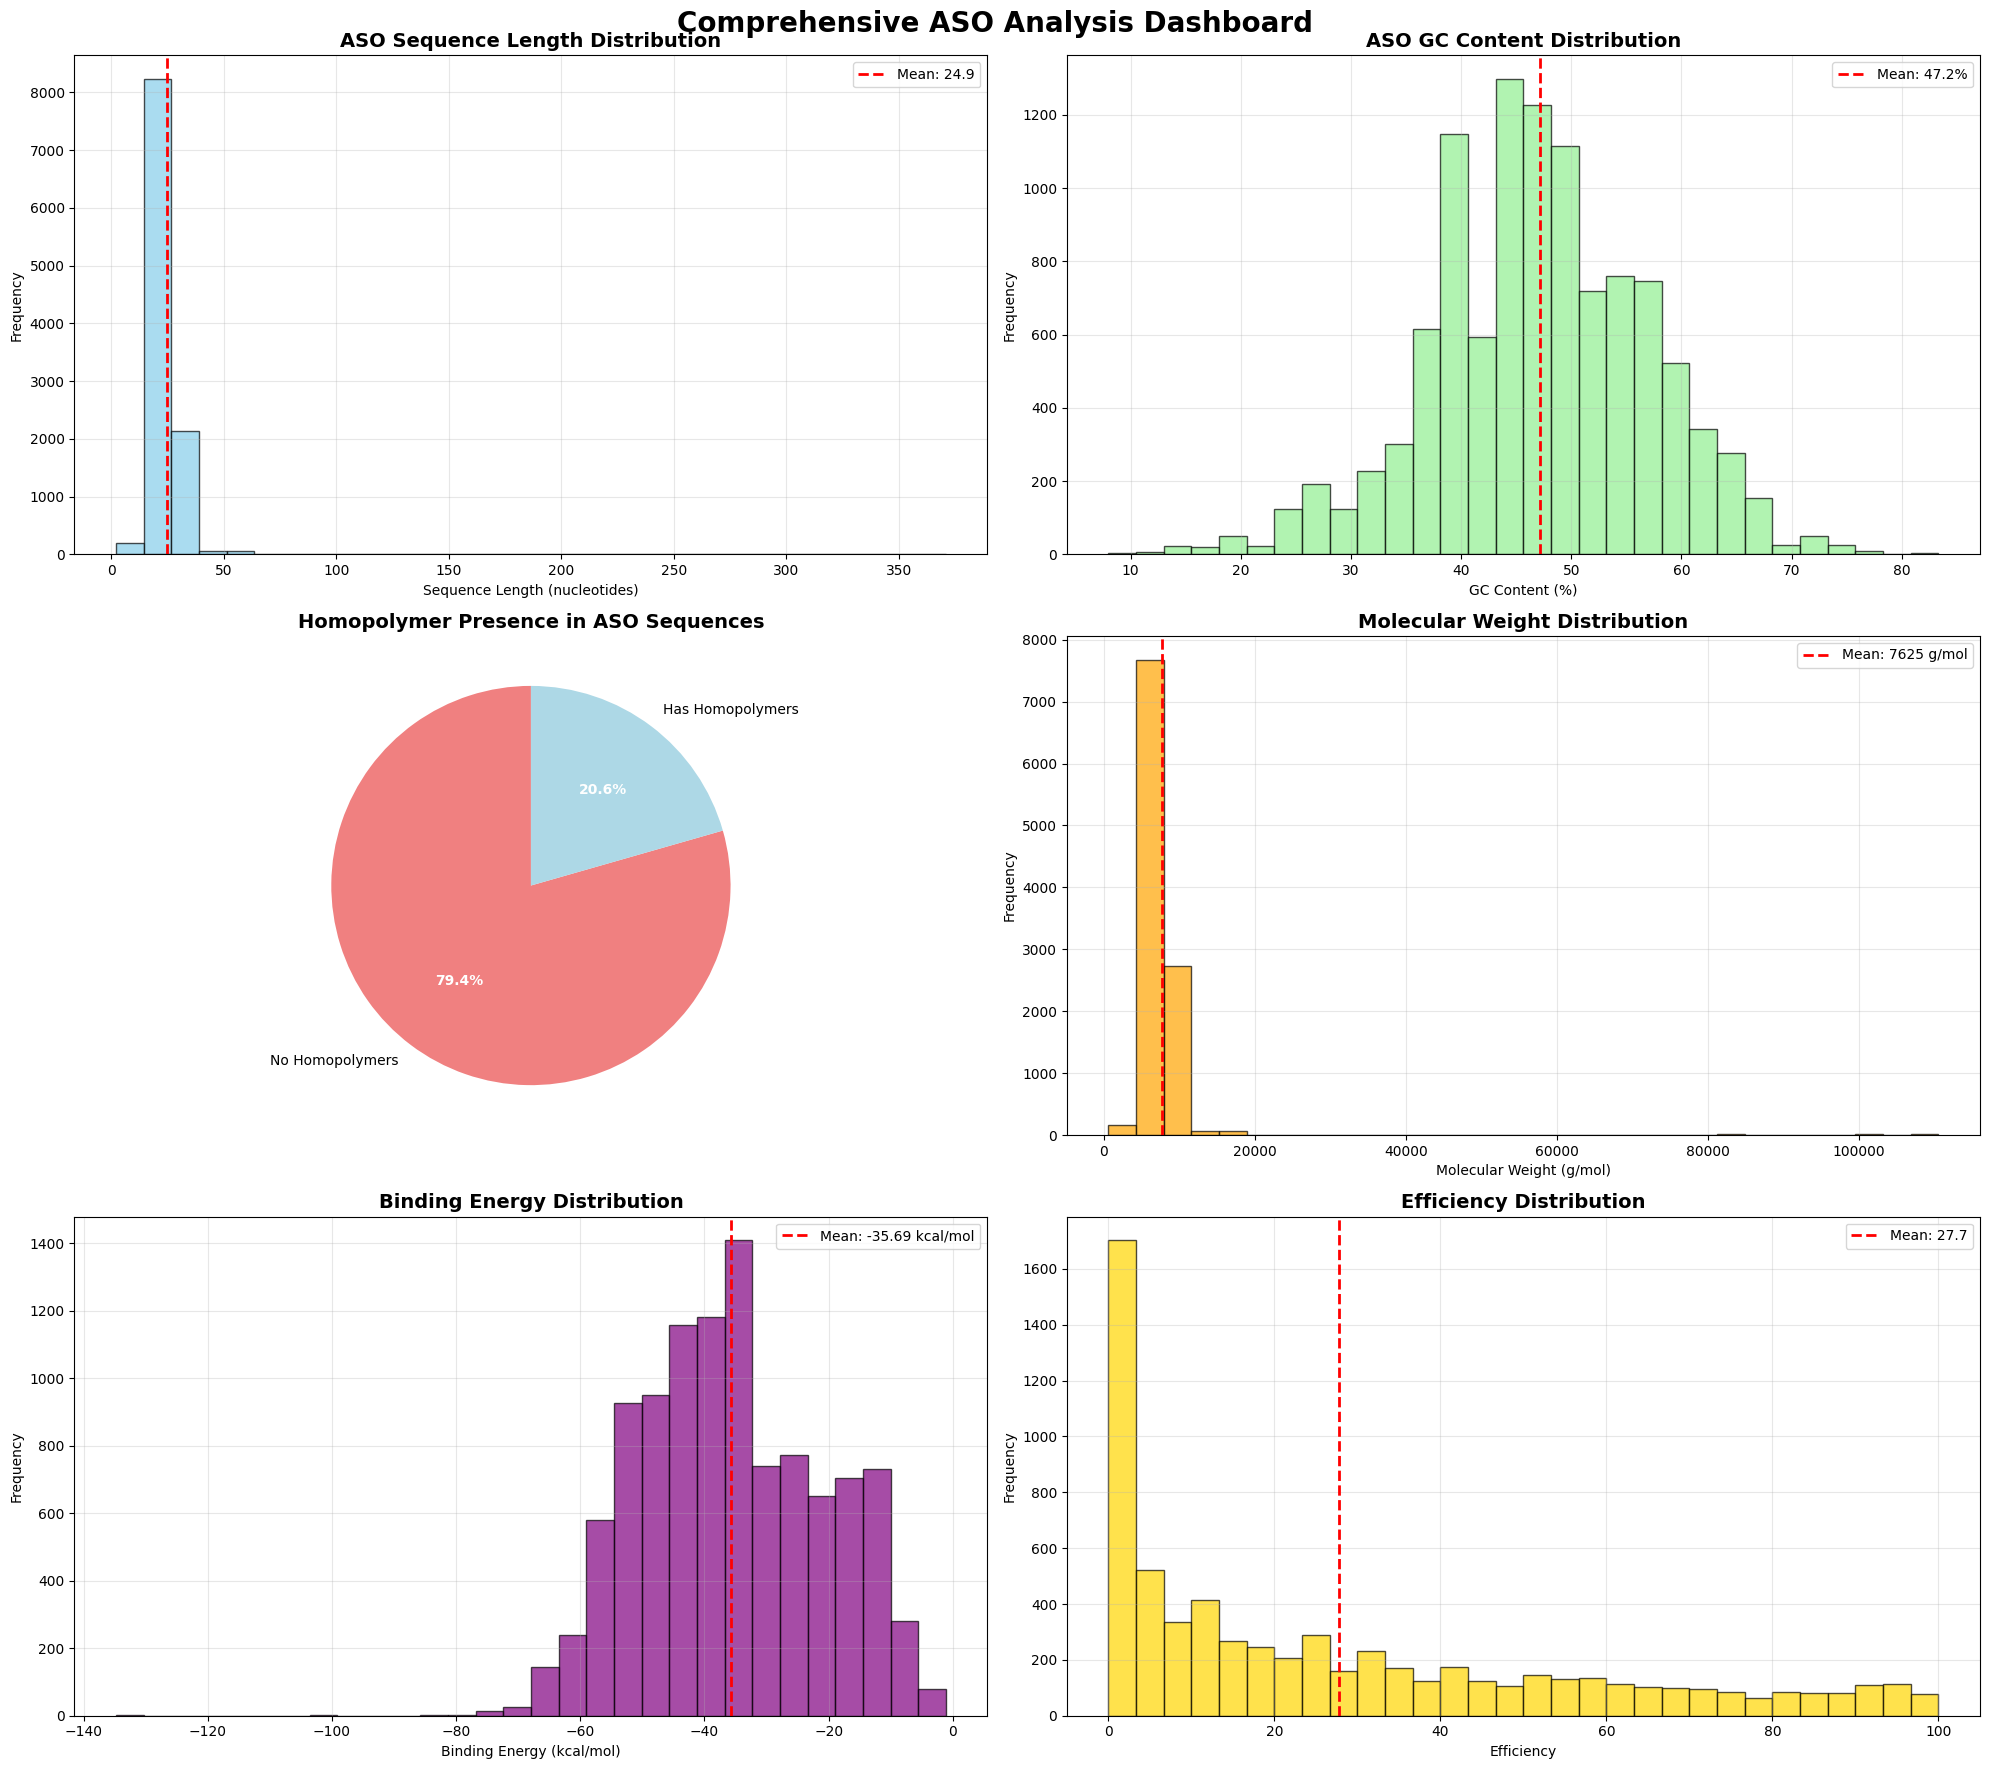

In [61]:
# Create comprehensive visualization dashboard
def create_comprehensive_dashboard(df):
    """
    Create a comprehensive visualization dashboard
    """
    print("📊 Creating comprehensive visualization dashboard...")

    # Calculate number of subplots needed
    n_plots = 6
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    fig.suptitle('Comprehensive ASO Analysis Dashboard', fontsize=20, fontweight='bold', y=0.98)

    # Plot 1: Sequence length distribution
    ax1 = axes[0, 0]
    if 'no_mod_ASO_length' in df.columns:
        lengths = df[df['no_mod_ASO_length'] > 0]['no_mod_ASO_length']
        if len(lengths) > 0:
            ax1.hist(lengths, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
            ax1.set_title('ASO Sequence Length Distribution', fontsize=14, fontweight='bold')
            ax1.set_xlabel('Sequence Length (nucleotides)')
            ax1.set_ylabel('Frequency')
            ax1.grid(True, alpha=0.3)

            # Add statistics
            mean_len = lengths.mean()
            ax1.axvline(mean_len, color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {mean_len:.1f}')
            ax1.legend()
    else:
        ax1.text(0.5, 0.5, 'Sequence length data\nnot available',
                ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('ASO Sequence Length Distribution', fontsize=14, fontweight='bold')

    # Plot 2: GC content distribution
    ax2 = axes[0, 1]
    if 'no_mod_ASO_gc_content' in df.columns:
        gc_content = df[df['no_mod_ASO_gc_content'] > 0]['no_mod_ASO_gc_content']
        if len(gc_content) > 0:
            ax2.hist(gc_content, bins=30, alpha=0.7, edgecolor='black', color='lightgreen')
            ax2.set_title('ASO GC Content Distribution', fontsize=14, fontweight='bold')
            ax2.set_xlabel('GC Content (%)')
            ax2.set_ylabel('Frequency')
            ax2.grid(True, alpha=0.3)

            # Add statistics
            mean_gc = gc_content.mean()
            ax2.axvline(mean_gc, color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {mean_gc:.1f}%')
            ax2.legend()
    else:
        ax2.text(0.5, 0.5, 'GC content data\nnot available',
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('ASO GC Content Distribution', fontsize=14, fontweight='bold')

    # Plot 3: Homopolymer analysis
    ax3 = axes[1, 0]
    if 'no_mod_ASO_has_homopolymers' in df.columns:
        homo_counts = df['no_mod_ASO_has_homopolymers'].value_counts()
        if len(homo_counts) > 0:
            labels = ['No Homopolymers', 'Has Homopolymers']
            colors = ['lightcoral', 'lightblue']
            wedges, texts, autotexts = ax3.pie(homo_counts.values, labels=labels,
                                              autopct='%1.1f%%', colors=colors, startangle=90)
            ax3.set_title('Homopolymer Presence in ASO Sequences', fontsize=14, fontweight='bold')

            # Improve text readability
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
    else:
        ax3.text(0.5, 0.5, 'Homopolymer data\nnot available',
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Homopolymer Presence in ASO Sequences', fontsize=14, fontweight='bold')

    # Plot 4: Molecular weight distribution
    ax4 = axes[1, 1]
    if 'molecular_weight' in df.columns:
        mw_data = df[df['molecular_weight'] > 0]['molecular_weight']
        if len(mw_data) > 0:
            ax4.hist(mw_data, bins=30, alpha=0.7, edgecolor='black', color='orange')
            ax4.set_title('Molecular Weight Distribution', fontsize=14, fontweight='bold')
            ax4.set_xlabel('Molecular Weight (g/mol)')
            ax4.set_ylabel('Frequency')
            ax4.grid(True, alpha=0.3)

            # Add statistics
            mean_mw = mw_data.mean()
            ax4.axvline(mean_mw, color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {mean_mw:.0f} g/mol')
            ax4.legend()
    else:
        ax4.text(0.5, 0.5, 'Molecular weight data\nnot available',
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Molecular Weight Distribution', fontsize=14, fontweight='bold')

    # Plot 5: Energy analysis (if available)
    ax5 = axes[2, 0]
    if 'bestdG' in df.columns:
        energy_data = df[df['bestdG'] < 0]['bestdG']  # Only favorable binding energies
        if len(energy_data) > 0:
            ax5.hist(energy_data, bins=30, alpha=0.7, edgecolor='black', color='purple')
            ax5.set_title('Binding Energy Distribution', fontsize=14, fontweight='bold')
            ax5.set_xlabel('Binding Energy (kcal/mol)')
            ax5.set_ylabel('Frequency')
            ax5.grid(True, alpha=0.3)

            # Add statistics
            mean_energy = energy_data.mean()
            ax5.axvline(mean_energy, color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {mean_energy:.2f} kcal/mol')
            ax5.legend()
        else:
            ax5.text(0.5, 0.5, 'No favorable binding\nenergies found',
                    ha='center', va='center', transform=ax5.transAxes)
            ax5.set_title('Binding Energy Distribution', fontsize=14, fontweight='bold')
    else:
        ax5.text(0.5, 0.5, 'Energy analysis data\nnot available',
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Binding Energy Distribution', fontsize=14, fontweight='bold')

    # Plot 6: Efficiency analysis (if available)
    ax6 = axes[2, 1]
    if 'efficiency' in df.columns:
        # Try to extract numeric efficiency values
        numeric_efficiency = pd.to_numeric(df['efficiency'], errors='coerce')
        valid_efficiency = numeric_efficiency.dropna()

        if len(valid_efficiency) > 0:
            ax6.hist(valid_efficiency, bins=30, alpha=0.7, edgecolor='black', color='gold')
            ax6.set_title('Efficiency Distribution', fontsize=14, fontweight='bold')
            ax6.set_xlabel('Efficiency')
            ax6.set_ylabel('Frequency')
            ax6.grid(True, alpha=0.3)

            # Add statistics
            mean_eff = valid_efficiency.mean()
            ax6.axvline(mean_eff, color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {mean_eff:.1f}')
            ax6.legend()
        else:
            ax6.text(0.5, 0.5, 'No numeric efficiency\nvalues found',
                    ha='center', va='center', transform=ax6.transAxes)
            ax6.set_title('Efficiency Distribution', fontsize=14, fontweight='bold')
    else:
        ax6.text(0.5, 0.5, 'Efficiency data\nnot available',
                ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Efficiency Distribution', fontsize=14, fontweight='bold')

    plt.tight_layout()

    # Save the plot
    output_path = OUTPUT_DIR / 'comprehensive_aso_dashboard.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"📊 Dashboard saved to: {output_path}")

    plt.show()

# Create the dashboard
create_comprehensive_dashboard(df)

In [63]:
df.head(5)

,source_type,name,id,target_gene,exon_or_intron,number_exon_intron,target_variant,species,cell_line,delivery_approach,aso_type,oligo_sequence,modification,modification_mask,concentration,concentration_unit,type_of_efficiency,efficiency,efficiency_units,efficiency_text,comment,DNA.RNA,link,top1_hit,top1_real,top1_predicted,no_mod_ASO,no_mod_ASO_count,no_mod_ASO_max_length,no_mod_ASO_has_homopolymers,no_mod_ASO_length,no_mod_ASO_gc_content,molecular_weight,converted_value_uM,a_numeric,gene_symbol,exon_number,sequence,sequence_count,sequence_max_length,sequence_has_homopolymers,sequence_length,sequence_gc_content,bestdG,binding_site,MFE_ASO,mfe_aso_structure,MFE_exon,mfe_exon_structure
0,journal article,Antisense-Induced Exon Skipping Restores Dystr...,PMID 11468272,DMD,exon,46.0,NaN,human,"Primary human myotubes (healthy, del45)","PEI, AON linked to PEI at a ratio of 3.5",NaN,guuaucugcuuccuccaacc,2OMe,NaN,1,uM,Null,unspecified,NaN,NaN,NaN,RNA,https://pubmed.ncbi.nlm.nih.gov/11468272,ERROR,ERROR,ERROR,GUUAUCUGCUUCCUCCAACC,0,0,False,20,50.000000,5960.715,167.765109,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True,148,35.135135,-36.4,GGTTGGAGGAAGCAGATAAC,0.0,....................,-19.799999,((((..(((((((((((...)))).((((((((((...)))))))....
1,journal article,Antisense-Induced Exon Skipping Restores Dystr...,PMID 11468272,DMD,exon,46.0,NaN,human,"Primary human myotubes (healthy, del45)","PEI, AON linked to PEI at a ratio of 3.5",NaN,uugcugcucuuuucc,2OMe,NaN,1,uM,Null,unspecified,NaN,NaN,NaN,RNA,https://pubmed.ncbi.nlm.nih.gov/11468272,ERROR,ERROR,ERROR,UUGCUGCUCUUUUCC,1,4,True,15,46.666667,4443.790,225.033136,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True,148,35.135135,-24.5,GGAAAAGAGCAGCAA,0.0,...............,-19.799999,((((..(((((((((((...)))).((((((((((...)))))))....
2,journal article,Comparative Analysis Of Antisense Oligonucleot...,PMID 15229633,DMD,exon,46.0,NaN,human,Primary healthy human myotubes,"PEI, 3.5 ul per ug AO",NaN,gcttttcttttagttgctgctc,unmodified PMO,NaN,1,uM,Skip,6,NaN,NaN,NaN,DNA,https://pubmed.ncbi.nlm.nih.gov/15229633,ERROR,ERROR,ERROR,GCTTTTCTTTTAGTTGCTGCTC,2,4,True,22,40.909091,6744.085,148.278084,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True,148,35.135135,-35.4,GAGCAGCAACTAAAAGAAAAGC,0.0,......................,-19.799999,((((..(((((((((((...)))).((((((((((...)))))))....
3,journal article,Comparative Analysis Of Antisense Oligonucleot...,PMID 15229633,DMD,exon,46.0,NaN,human,Primary healthy human myotubes,"PEI, 3.5 ul per ug AO",NaN,cttttagttgctgc,Others (LNA),NaN,500,nM,Skip,85,NaN,NaN,NaN,DNA,https://pubmed.ncbi.nlm.nih.gov/15229633,ERROR,ERROR,ERROR,CTTTTAGTTGCTGC,1,4,True,14,42.857143,4315.605,115858.610786,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True,148,35.135135,-20.3,GCAGCAACTAAAAG,0.0,..............,-19.799999,((((..(((((((((((...)))).((((((((((...)))))))....
4,journal article,Comparative Analysis Of Antisense Oligonucleot...,PMID 15229633,DMD,exon,46.0,NaN,human,Primary healthy human myotubes,"PEI, 3.5 ul per ug AO",NaN,cttttagttgctgc,Others (PNA),NaN,20,uM,Null,data not shown,NaN,NaN,NaN,DNA,https://pubmed.ncbi.nlm.nih.gov/15229633,ERROR,ERROR,ERROR,CTTTTAGTTGCTGC,1,4,True,14,42.857143,4315.605,4634.344431,46.0,DMD,46.0,GCTAGAAGAACAAAAGAATATCTTGTCAGAATTTCAAAGAGATTTA...,5,4,True,148,35.135135,-20.3,GCAGCAACTAAAAG,0.0,..............,-19.799999,((((..(((((((((((...)))).((((((((((...)))))))....


## 10. Analysis Summary and Results

Generate a comprehensive summary of all analysis results.

In [62]:
# Generate comprehensive analysis summary
def generate_analysis_summary(df):
    """
    Generate a comprehensive summary of all analysis results
    """
    print("📋 COMPREHENSIVE ANALYSIS SUMMARY")
    print("=" * 70)

    # Dataset overview
    print(f"\n📊 Dataset Overview:")
    print(f"  • Total records: {len(df):,}")
    print(f"  • Total columns: {len(df.columns)}")
    print(f"  • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Sequence analysis summary
    print(f"\n🧬 Sequence Analysis Summary:")

    # ASO sequences
    if 'no_mod_ASO' in df.columns:
        aso_count = df['no_mod_ASO'].notna().sum()
        print(f"  • ASO sequences available: {aso_count:,} ({aso_count/len(df)*100:.1f}%)")

        if 'no_mod_ASO_length' in df.columns:
            valid_lengths = df[df['no_mod_ASO_length'] > 0]['no_mod_ASO_length']
            if len(valid_lengths) > 0:
                print(f"    - Average length: {valid_lengths.mean():.1f} nucleotides")
                print(f"    - Length range: {valid_lengths.min()} - {valid_lengths.max()} nucleotides")

        if 'no_mod_ASO_gc_content' in df.columns:
            valid_gc = df[df['no_mod_ASO_gc_content'] > 0]['no_mod_ASO_gc_content']
            if len(valid_gc) > 0:
                print(f"    - Average GC content: {valid_gc.mean():.1f}%")
                print(f"    - GC content range: {valid_gc.min():.1f}% - {valid_gc.max():.1f}%")

    # Exon sequences
    if 'sequence' in df.columns:
        exon_count = df['sequence'].notna().sum()
        print(f"  • Exon sequences available: {exon_count:,} ({exon_count/len(df)*100:.1f}%)")

        if 'sequence_length' in df.columns:
            valid_lengths = df[df['sequence_length'] > 0]['sequence_length']
            if len(valid_lengths) > 0:
                print(f"    - Average length: {valid_lengths.mean():.1f} nucleotides")
                print(f"    - Length range: {valid_lengths.min()} - {valid_lengths.max()} nucleotides")

    # Homopolymer analysis summary
    print(f"\n🔗 Homopolymer Analysis Summary:")

    if 'no_mod_ASO_has_homopolymers' in df.columns:
        homo_count = df['no_mod_ASO_has_homopolymers'].sum()
        total_aso = df['no_mod_ASO_has_homopolymers'].notna().sum()
        if total_aso > 0:
            print(f"  • ASO sequences with homopolymers: {homo_count:,}/{total_aso:,} ({homo_count/total_aso*100:.1f}%)")

            if 'no_mod_ASO_max_length' in df.columns:
                max_homo_length = df['no_mod_ASO_max_length'].max()
                avg_homo_count = df[df['no_mod_ASO_has_homopolymers']]['no_mod_ASO_count'].mean()
                print(f"    - Maximum homopolymer length: {max_homo_length}")
                print(f"    - Average homopolymers per sequence: {avg_homo_count:.1f}")

    # Molecular weight analysis summary
    print(f"\n💊 Molecular Weight Analysis Summary:")

    if 'molecular_weight' in df.columns:
        mw_data = df[df['molecular_weight'] > 0]['molecular_weight']
        if len(mw_data) > 0:
            print(f"  • Sequences with calculated MW: {len(mw_data):,}")
            print(f"    - Average molecular weight: {mw_data.mean():.1f} g/mol")
            print(f"    - MW range: {mw_data.min():.1f} - {mw_data.max():.1f} g/mol")

    if 'converted_value_uM' in df.columns:
        conc_data = df[df['converted_value_uM'] > 0]['converted_value_uM']
        if len(conc_data) > 0:
            print(f"  • Sequences with converted concentrations: {len(conc_data):,}")
            print(f"    - Average concentration: {conc_data.mean():.2f} µM")
            print(f"    - Concentration range: {conc_data.min():.2f} - {conc_data.max():.2f} µM")

    # Energy analysis summary
    print(f"\n⚡ Energy Analysis Summary:")

    if 'bestdG' in df.columns:
        binding_data = df[df['bestdG'] < 0]['bestdG']
        if len(binding_data) > 0:
            print(f"  • Sequences with favorable binding energy: {len(binding_data):,}")
            print(f"    - Average binding energy: {binding_data.mean():.2f} kcal/mol")
            print(f"    - Binding energy range: {binding_data.min():.2f} - {binding_data.max():.2f} kcal/mol")
        else:
            print(f"  • No sequences with favorable binding energy found")

    if 'MFE_ASO' in df.columns:
        mfe_data = df[df['MFE_ASO'] != 0]['MFE_ASO']
        if len(mfe_data) > 0:
            print(f"  • ASO sequences with MFE calculated: {len(mfe_data):,}")
            print(f"    - Average MFE: {mfe_data.mean():.2f} kcal/mol")

    # Efficiency analysis summary
    print(f"\n📈 Efficiency Analysis Summary:")

    if 'efficiency' in df.columns:
        total_efficiency = df['efficiency'].notna().sum()
        print(f"  • Records with efficiency data: {total_efficiency:,} ({total_efficiency/len(df)*100:.1f}%)")

        # Analyze numeric vs text efficiency values
        numeric_efficiency = pd.to_numeric(df['efficiency'], errors='coerce')
        numeric_count = numeric_efficiency.notna().sum()
        text_count = total_efficiency - numeric_count

        print(f"    - Numeric efficiency values: {numeric_count:,}")
        print(f"    - Text efficiency values: {text_count:,}")

        if numeric_count > 0:
            print(f"    - Average efficiency: {numeric_efficiency.mean():.2f}")
            print(f"    - Efficiency range: {numeric_efficiency.min():.2f} - {numeric_efficiency.max():.2f}")

    # Data completeness analysis
    print(f"\n📊 Data Completeness Analysis:")
    completeness = ((df.notna().sum() / len(df)) * 100).sort_values(ascending=False)
    print(f"  • Most complete column: {completeness.index[0]} ({completeness.iloc[0]:.1f}%)")
    print(f"  • Least complete column: {completeness.index[-1]} ({completeness.iloc[-1]:.1f}%)")
    print(f"  • Average completeness: {completeness.mean():.1f}%")

    # Key findings and recommendations
    print(f"\n🔍 Key Findings and Recommendations:")

    # Sequence diversity
    if 'no_mod_ASO' in df.columns:
        unique_sequences = df['no_mod_ASO'].nunique()
        total_sequences = df['no_mod_ASO'].notna().sum()
        if total_sequences > 0:
            diversity = unique_sequences / total_sequences
            print(f"  • Sequence diversity: {diversity:.3f} ({unique_sequences:,} unique out of {total_sequences:,})")

    # Target gene analysis
    if 'target_gene' in df.columns:
        unique_genes = df['target_gene'].nunique()
        top_gene = df['target_gene'].value_counts().index[0]
        top_gene_count = df['target_gene'].value_counts().iloc[0]
        print(f"  • Target genes studied: {unique_genes}")
        print(f"  • Most studied gene: {top_gene} ({top_gene_count:,} records)")

    # Species analysis
    if 'species' in df.columns:
        unique_species = df['species'].nunique()
        top_species = df['species'].value_counts().index[0]
        top_species_count = df['species'].value_counts().iloc[0]
        print(f"  • Species studied: {unique_species}")
        print(f"  • Most common species: {top_species} ({top_species_count:,} records)")

    print(f"\n✅ Analysis completed successfully!")
    print(f"\n📝 Recommendations for further analysis:")
    print(f"  • Investigate efficiency patterns by target gene and species")
    print(f"  • Analyze sequence-efficiency relationships using machine learning")
    print(f"  • Compare homopolymer effects on binding energy and efficiency")
    print(f"  • Examine delivery method effectiveness across different conditions")
    print(f"  • Perform statistical modeling for efficiency prediction")
    print(f"  • Investigate optimal GC content and sequence length ranges")

# Generate the summary
generate_analysis_summary(df)

📋 COMPREHENSIVE ANALYSIS SUMMARY

📊 Dataset Overview:
  • Total records: 10,729
  • Total columns: 49
  • Memory usage: 23.06 MB

🧬 Sequence Analysis Summary:
  • ASO sequences available: 10,729 (100.0%)
    - Average length: 24.9 nucleotides
    - Length range: 2 - 371 nucleotides
    - Average GC content: 47.2%
    - GC content range: 8.0% - 83.3%
  • Exon sequences available: 10,720 (99.9%)
    - Average length: 187.8 nucleotides
    - Length range: 18 - 4379 nucleotides

🔗 Homopolymer Analysis Summary:
  • ASO sequences with homopolymers: 2,206/10,729 (20.6%)
    - Maximum homopolymer length: 13
    - Average homopolymers per sequence: 1.2

💊 Molecular Weight Analysis Summary:
  • Sequences with calculated MW: 10,729
    - Average molecular weight: 7624.6 g/mol
    - MW range: 597.4 - 110572.4 g/mol
  • Sequences with converted concentrations: 8,025
    - Average concentration: 3669.59 µM
    - Concentration range: 0.00 - 334792.47 µM

⚡ Energy Analysis Summary:
  • Sequences with 

## 11. Save Results

Save all analysis results to files for future use.

In [ ]:
# Save all results
print("💾 Saving analysis results...")

# Save the complete processed dataset
output_file = OUTPUT_DIR / 'comprehensive_aso_analysis_complete.csv'
df.to_csv(output_file, index=False)
print(f"✅ Complete dataset saved to: {output_file}")

# Save a summary of new columns created
original_columns = ['source_type', 'name', 'id', 'target_gene', 'exon_or_intron',
                   'number_exon_intron', 'species', 'cell_line', 'delivery_approach',
                   'efficiency', 'efficiency_units', 'DNA.RNA', 'no_mod_ASO']

new_columns = [col for col in df.columns if col not in original_columns]

summary_file = OUTPUT_DIR / 'analysis_summary.txt'
with open(summary_file, 'w') as f:
    f.write("Comprehensive ASO Analysis Summary\n")
    f.write("=" * 40 + "\n\n")
    f.write(f"Original dataset shape: {df.shape}\n")
    f.write(f"New columns added: {len(new_columns)}\n\n")
    f.write("New columns:\n")
    for col in new_columns:
        f.write(f"  - {col}\n")
    f.write("\nAnalysis completed successfully!\n")

print(f"✅ Analysis summary saved to: {summary_file}")

# Display final statistics
print(f"\n📊 Final Dataset Statistics:")
print(f"  • Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"  • New columns added: {len(new_columns)}")
print(f"  • Output directory: {OUTPUT_DIR}")

print(f"\n🎉 Comprehensive ASO analysis pipeline completed successfully!")